# How Popular is Matplotlib?

Anecdotally the Matplotlib maintainers were told 

*"About 15% of arXiv papers use Matplotlib"*

arXiv is the preeminent repository for scholarly prepreint articles.  It stores millions of journal articles used across science.  It's also public access, and so we can just scrape the entire thing given enough compute power.

## Watermark

Starting in the early 2010s, Matplotlib started including the bytes `b"Matplotlib"` in every PNG and PDF that they produce.  These bytes persist in PDFs that contain Matplotlib plots, including the PDFs stored on arXiv.  As a result, it's pretty simple to check if a PDF contains a Matplotlib image.  All we have to do is scan through every PDF and look for these bytes; no parsing required.

## Data

The data is stored in a requester pays bucket at s3://arxiv (more information at https://arxiv.org/help/bulk_data_s3 ) and also on GCS hosted by Kaggle (more information at https://www.kaggle.com/datasets/Cornell-University/arxiv).  

The data is about 1TB in size.  We're going to use Dask for this.

This is a good example of writing plain vanilla Python code to solve a problem, running into issues of scale, and then using Dask to easily jump over those problems.

### Get all filenames

Our data is stored in a requester pays S3 bucket in the `us-east-1` region.  Each file is a tar file which contains a directory of papers.

In [1]:
import s3fs
s3 = s3fs.S3FileSystem(requester_pays=True)

directories = s3.ls("s3://arxiv/pdf")
directories[:10]

['arxiv/pdf/arXiv_pdf_0001_001.tar',
 'arxiv/pdf/arXiv_pdf_0001_002.tar',
 'arxiv/pdf/arXiv_pdf_0002_001.tar',
 'arxiv/pdf/arXiv_pdf_0002_002.tar',
 'arxiv/pdf/arXiv_pdf_0003_001.tar',
 'arxiv/pdf/arXiv_pdf_0003_002.tar',
 'arxiv/pdf/arXiv_pdf_0004_001.tar',
 'arxiv/pdf/arXiv_pdf_0004_002.tar',
 'arxiv/pdf/arXiv_pdf_0005_001.tar',
 'arxiv/pdf/arXiv_pdf_0005_002.tar']

In [2]:
directories[1000]

'arxiv/pdf/arXiv_pdf_1407_009.tar'

There are lots of these

In [3]:
len(directories)

5373

## Process one file with plain Python

Mostly we have to muck about with tar files.  This wasn't hard.  The `tarfile` library is in the stardard library.  It's not beautiful, but it's also not hard to use.

In [4]:
import tarfile
import io

def extract(filename: str):
    """ Extract and process one directory of arXiv data
    
    Returns
    -------
    filename: str
    contains_matplotlib: boolean
    """
    out = []
    with s3.open(filename) as f:
        bytes = f.read()
        with io.BytesIO() as bio:
            bio.write(bytes)
            bio.seek(0)
            with tarfile.TarFile(fileobj=bio) as tf:
                for member in tf.getmembers():
                    if member.isfile() and member.name.endswith(".pdf"):
                        data = tf.extractfile(member).read()
                        out.append((
                            member.name, 
                            b"matplotlib" in data.lower()
                        ))
            return out

In [5]:
%%time

# See an example of its use
extract(directories[20])[:20]

CPU times: user 3.99 s, sys: 1.79 s, total: 5.78 s
Wall time: 51.5 s


[('0011/cs0011019.pdf', False),
 ('0011/gr-qc0011017.pdf', False),
 ('0011/hep-ex0011095.pdf', False),
 ('0011/cond-mat0011373.pdf', False),
 ('0011/hep-ph0011035.pdf', False),
 ('0011/gr-qc0011082.pdf', False),
 ('0011/cond-mat0011202.pdf', False),
 ('0011/hep-ph0011209.pdf', False),
 ('0011/cond-mat0011038.pdf', False),
 ('0011/gr-qc0011014.pdf', False),
 ('0011/hep-ph0011118.pdf', False),
 ('0011/gr-qc0011095.pdf', False),
 ('0011/astro-ph0011090.pdf', False),
 ('0011/hep-ph0011162.pdf', False),
 ('0011/cs0011010.pdf', False),
 ('0011/cond-mat0011086.pdf', False),
 ('0011/hep-lat0011037.pdf', False),
 ('0011/astro-ph0011369.pdf', False),
 ('0011/astro-ph0011187.pdf', False),
 ('0011/astro-ph0011074.pdf', False)]

# Scale function to full dataset

Great, we can get a record of each file and whether or not it used Matplotlib.  Each of these takes about a minute to run on my local machine.  Processing all 5000 files would take 5000 minutes, or around 100 hours.  

We can accelerate this in two ways:

1.  **Process closer to the data** by spinning up resources in the same region on the cloud (this also reduces data transfer costs)
2.  **Use hundreds of workers** in parallel

We can do this easily with Dask (parallel computing) and Coiled (set up Dask infrastructure)

## Create Dask Cluster

We start a Dask cluster on AWS in the same region where the data is stored.  

We mimic the local software environment on the cluster with `package_sync=True`.

In [6]:
%%time

import coiled

cluster = coiled.Cluster(
    n_workers=100,
    name="arxiv",
    package_sync=True, 
    backend_options={"region": "us-east-1"},  # faster and cheaper
)

╭───────────────────────────────────────── Package Issues ─────────────────────────────────────────╮
│                    ╷                                                           ╷                 │
│   Package          │ Issue                                                     │ Risk Level      │
│ ╶──────────────────┼───────────────────────────────────────────────────────────┼───────────────╴ │
│   libgfortran5     │ 11.3.0 has no install candidate for linux-64              │                 │
│   libgfortran      │ 5.0.0 has no install candidate for linux-64               │                 │
│   grpcio           │ 1.47.1 has no install candidate for linux-64              │                 │
│   grpc-cpp         │ 1.47.1 has no install candidate for linux-64              │                 │
│   arrow-cpp        │ 9.0.0 has no install candidate for linux-64               │                 │
│   openssl          │ Package ignored                                           │                 │
│   libabseil        │ Package ignored                                           │                 │
│                    ╵                                                           ╵                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

CPU times: user 9.72 s, sys: 1.08 s, total: 10.8 s
Wall time: 1min 25s


In [7]:
from dask.distributed import Client, wait
client = Client(cluster)

/Users/mrocklin/mambaforge/envs/play/lib/python3.10/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+----------+
| Package     | Client    | Scheduler | Workers  |
+-------------+-----------+-----------+----------+
| dask        | 2022.10.0 | 2022.9.1  | 2022.9.1 |
| distributed | 2022.10.0 | 2022.9.1  | 2022.9.1 |
+-------------+-----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


### Map function across every directory

Let's scale up this work across all of the directories in our dataset

Hopefully it will also be faster because the Dask workers are in the same region as the dataset itself.

In [8]:
%%time

futures = client.map(extract, directories)
wait(futures)

# We had one error in one file.  Let's just ignore and move on.
good = [future for future in futures if future.status == "finished"]

lists = client.gather(good)

CPU times: user 11.7 s, sys: 1.77 s, total: 13.5 s
Wall time: 5min 58s


Now that we're done with the large data problem we can turn off Dask and proceed with pure Pandas.  There's no reason to deal with scalable tools if we don't have to.

In [9]:
# Scale down now that we're done
cluster.close()

## Enrich Data

Let's enhance our data a bit.  The filenames of each file include the year and month when they were published.  After extracting this data we'll be able to see a timeseries of Matplotlib adoption.

In [10]:
# Convert to Pandas

import pandas as pd

dfs = [
    pd.DataFrame(list, columns=["filename", "has_matplotlib"]) 
    for list in lists
]

df = pd.concat(dfs)

df

,filename,has_matplotlib
0,0001/astro-ph0001477.pdf,False
1,0001/hep-th0001095.pdf,False
2,0001/astro-ph0001322.pdf,False
3,0001/cond-mat0001159.pdf,False
4,0001/astro-ph0001132.pdf,False
...,...,...
630,9912/math9912098.pdf,False
631,9912/math9912251.pdf,False
632,9912/solv-int9912013.pdf,False
633,9912/hep-th9912254.pdf,False


In [11]:
def date(filename):
    year = int(filename.split("/")[0][:2])
    month = int(filename.split("/")[0][2:4])
    if year > 80:
        year = 1900 + year
    else:
        year = 2000 + year
    
    return pd.Timestamp(year=year, month=month, day=1)

date("0005/astro-ph0001322.pdf")

Timestamp('2000-05-01 00:00:00')

Yup.  That seems to work.  Let's map this function over our dataset.

In [12]:
df["date"] = df.filename.map(date)
df.head()

,filename,has_matplotlib,date
0,0001/astro-ph0001477.pdf,False,2000-01-01
1,0001/hep-th0001095.pdf,False,2000-01-01
2,0001/astro-ph0001322.pdf,False,2000-01-01
3,0001/cond-mat0001159.pdf,False,2000-01-01
4,0001/astro-ph0001132.pdf,False,2000-01-01


## Plot

Now we can just fool around with Pandas and Matplotlib.

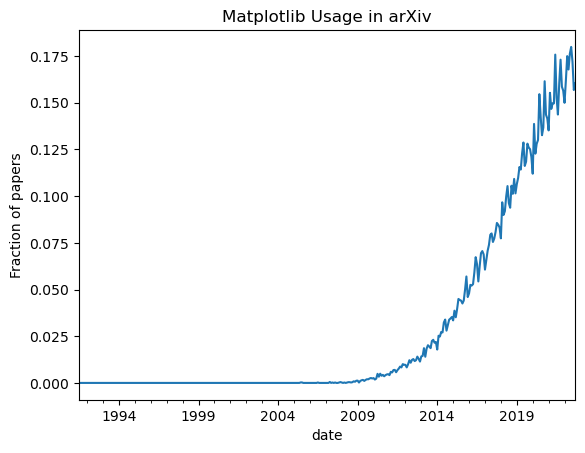

In [13]:
df.groupby("date").has_matplotlib.mean().plot(
    title="Matplotlib Usage in arXiv", 
    ylabel="Fraction of papers"
).get_figure().savefig("results.png")

I did the plot above.  Then Thomas Caswell (matplotlib maintainer) came by and, in true form, made something much better 🙂

Text(0.5, 1.0, 'Matplotlib usage on arXiv')

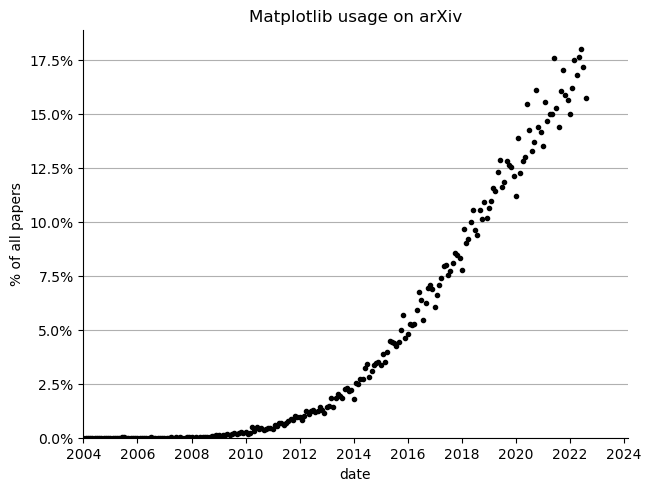

In [14]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pandas as pd

# read data
by_month = pd.read_parquet("results.parquet").groupby("date").has_matplotlib.mean()


# get figure
fig, ax = plt.subplots(layout="constrained")
# plot the data
ax.plot(by_month, "o", color="k", ms=3)

# over-ride the default auto limits
ax.set_xlim(left=datetime.date(2004, 1, 1))
ax.set_ylim(bottom=0)

# turn on a horizontal grid
ax.grid(axis="y")

# remove the top and right spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# format y-ticks a percent
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# add title and labels
ax.set_xlabel("date")
ax.set_ylabel("% of all papers")
ax.set_title("Matplotlib usage on arXiv")

Yup.  Matplotlib is used pretty commonly on arXiv.  Go team.

## Save results

This data was slighly painful to procure.  Let's save the results locally for future analysis.  That way other researchers can further analyze the results without having to muck about with parallelism or cloud stuff.

In [ ]:
df.to_csv("arxiv-matplotlib.csv")

In [ ]:
!du -hs arxiv-matplotlib.csv

In [ ]:
df.to_parquet("arxiv-matplotlib.parquet", compression="snappy")

In [ ]:
!du -hs arxiv-matplotlib.parquet

## Conclusion

### Matplotlib + arXiv

It's incredible to see the steady growth of Matplotlib across arXiv.  It's worth noting that this is *all* papers, even from fields like theoretical mathematics that are unlikely to include computer generated plots.  Is this matplotlib growing in popularity?  Is it Python generally?

For future work, we should break this down by subfield.  The filenames actually contained the name of the field for a while, like "hep-ex" for "high energy physics, experimental", but it looks like arXiv stopped doing this at some point.  My guess is that there is a list mapping filenames to fields somewhere though.  The filenames are all in the Pandas dataframe / parquet dataset, so doing this analysis shouldn't require any scalable computing.

### Dask + Coiled

Dask and Coiled were built to make it easy to answer large questions.  

We started this notebook with some generic Python code.  When we wanted to scale up we invoked Dask+Coiled, did some work, and then tore things down, all in about ten minutes.  The problem of scale or "big data" didn't get in the way of us analyzing data and making a delightful discovery. 

This is exactly why these projects exist.